# Volume Data in FLOW - Exploratory Analysis
### Temporal Distribution Plots 
Note: In all plots, segments refer to unique directional centreline segments

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import preprocess
from pg import DB
import numpy as np
import configparser

### Function: PHistogram 
Define a function for plotting histograms given a dataframe and plot parameters.

In [2]:
def PHistogram(title, xlabel, ylabel, df, col, color):
    ''' This function creates a new plot and plot histogram based on parameters given.
        INPUT: title: plot title
                xlabel, ylabel: axes labels
                df: dataframe to be plotted
                col: column name in the df to be plotted
                color: color of bars'''
    maxValue = max(df[col])    
    fig, ax = plt.subplots(figsize = [maxValue/2,5])

    bins = [i+0.5 for i in list(range(maxValue))]
    n,bins,patches=plt.hist(df[col],bins=bins,color=color)
    
    plt.xlim([0.5,maxValue+0.5])
    plt.ylim([0,14000])
    ax.get_xaxis().set_visible(False)
    for count,x in zip (n,bins[:-1]):
        ax.annotate(str(int(count)), xy=(x+0.5,0), xycoords=('data', 'axes fraction'),
            xytext=(0, -25), textcoords='offset points', va='top', ha='center')
        ax.annotate(str(int(x+0.5)), xy=(x+0.5,0), xycoords=('data', 'axes fraction'),
            xytext=(0, -10), textcoords='offset points', va='top', ha='center')
    plt.subplots_adjust(bottom=0.15)
    plt.title(title)
    ax.annotate(xlabel, xy=(maxValue+0.5,0), xycoords=('data', 'axes fraction'), 
        xytext=(0, -10), textcoords='offset points', va='top', ha='left')
    ax.set_ylabel(ylabel)

### DB Setup and Data Input 
Connect to the Postgres instance and import data into a dataframe.

In [3]:
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
db = DB(dbname=dbset['database'],host=dbset['host'],user=dbset['user'],passwd=dbset['password'])

In [4]:
data = pd.read_csv('coverage_summary.csv')
data = data.dropna()
data['year'] = data['year'].astype(int)
data['month'] = data['month'].astype(int)
data['season'] = data.apply(preprocess.makeseasons,axis=1)
centrelines = pd.DataFrame(db.query('SELECT centreline_id, feature_code_desc FROM prj_volume.centreline').getresult(), columns = ['centreline_id','feature_code_desc'])
data = data.merge(centrelines, on='centreline_id', how='inner')

### 1. Number of Segments vs. Number of Years Counted 
The following plot details the overall temporal spread of volume data (in unique years of data available) by number of segments in each bin. The x-axis represents the number of unique years for which data for a particular segment is available.

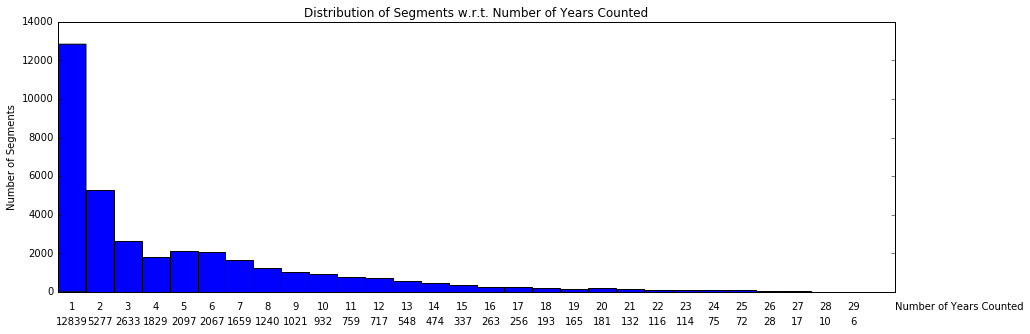

In [21]:
data1 = pd.DataFrame(data.groupby(['centreline_id','dir_bin']).year.nunique())
data1.reset_index(inplace=True)

PHistogram('Distribution of Segments w.r.t. Number of Years Counted','Number of Years Counted','Number of Segments',data1,'year','blue')

### 2. Number of Segments vs. Number of Years (ATR only) 
Similar to Plot 1, but filtered for ATR locations only.

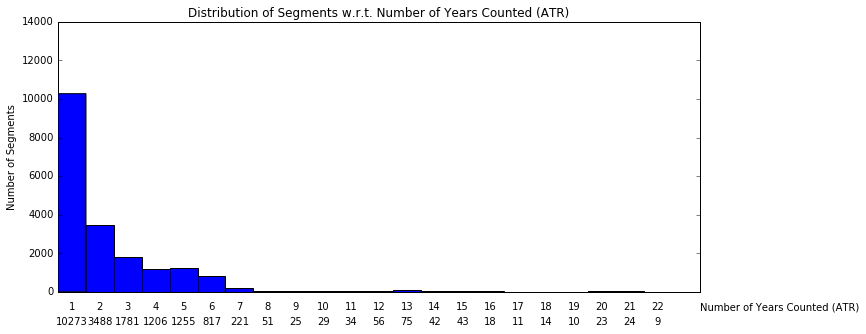

In [22]:
data1 = data[data['count_type']==1]    
data1 = pd.DataFrame(data1.groupby(['centreline_id','dir_bin']).year.nunique())
data1.reset_index(inplace=True)

PHistogram('Distribution of Segments w.r.t. Number of Years Counted (ATR)','Number of Years Counted (ATR)','Number of Segments',data2,'year','blue')

### 3. Distribution of Segments in Different Seasons 
Similar to Plot 1, but segmented by the four seasons of the year.

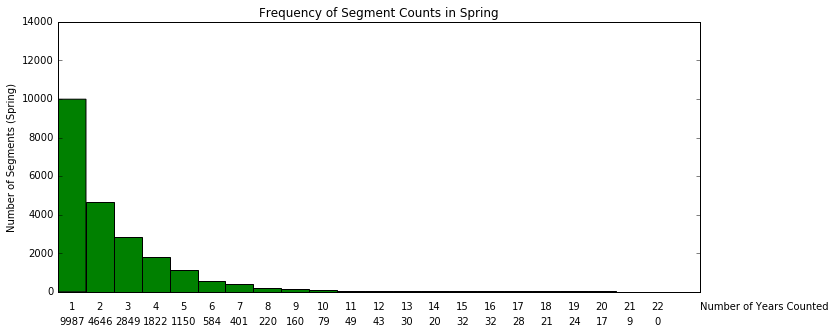

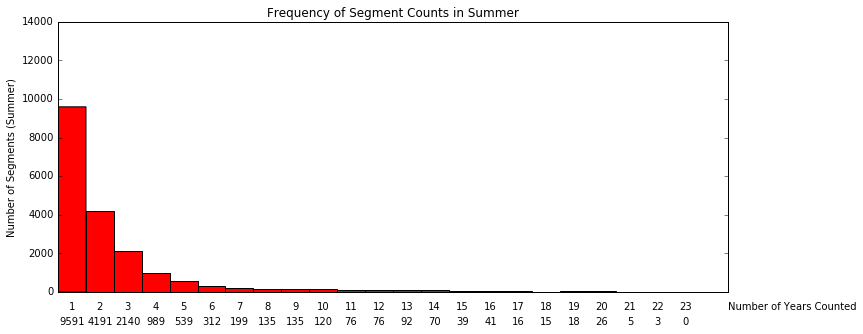

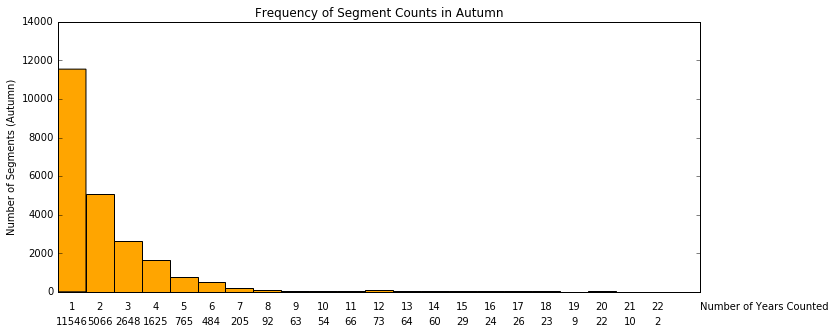

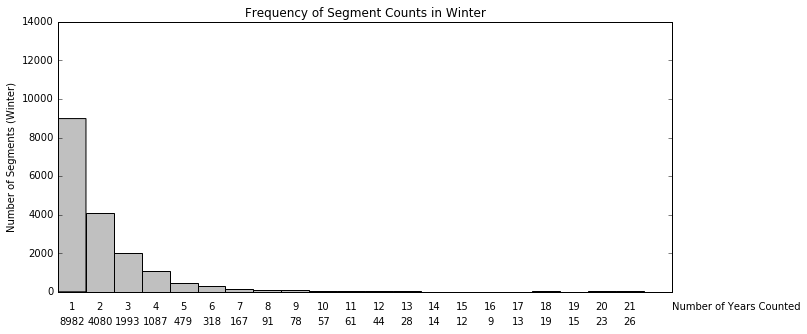

In [27]:
data1 = pd.DataFrame(data.groupby(['centreline_id','dir_bin','season']).year.nunique())
data1.reset_index(inplace=True)

PHistogram('Frequency of Segment Counts in Spring','Number of Years Counted','Number of Segments (Spring)',data3[data3['season']=='Spring'],'year','green')
PHistogram('Frequency of Segment Counts in Summer','Number of Years Counted','Number of Segments (Summer)',data3[data3['season']=='Summer'],'year','red')
PHistogram('Frequency of Segment Counts in Autumn','Number of Years Counted','Number of Segments (Autumn)',data3[data3['season']=='Autumn'],'year','orange')
PHistogram('Frequency of Segment Counts in Winter','Number of Years Counted','Number of Segments (Winter)',data3[data3['season']=='Winter'],'year','silver')


### 4. Number of Count Days in Each Year 
Number of count days (segments x direction x days) for each year.

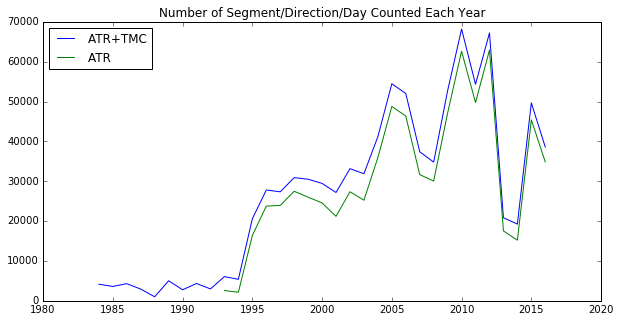

In [28]:
fig, ax = plt.subplots(figsize = [10,5])
data1 = data.groupby(['year'],as_index=False).count()
plt.plot(data1['year'],data1['centreline_id'],label="ATR+TMC")
data1 = data[data['count_type'] == 1].groupby(['year'],as_index=False).count()
plt.plot(data1['year'],data1['centreline_id'],label="ATR")
plt.title('Number of Segment/Direction/Day Counted Each Year')
plt.legend(loc=2)

### 5. Number of Count Days Separated by Day of Week Each Year 
Number of count days (segments x direction x days) for each year, segmented by weekday and weekend counts.

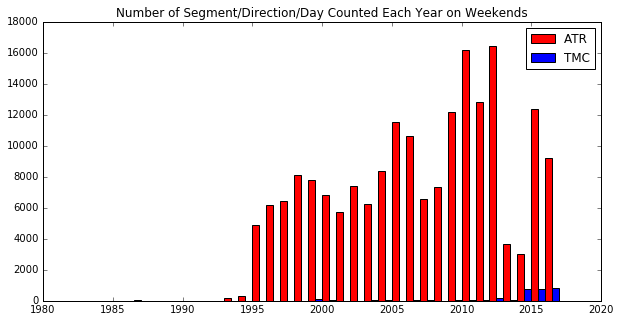

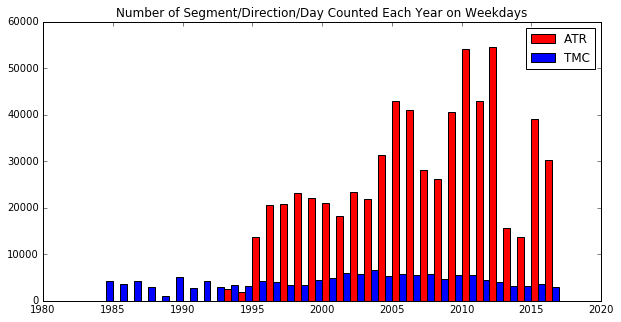

In [31]:
fig, ax = plt.subplots(figsize = [10,5])
data1 = data[(data['dow'] == 0) | (data['dow'] == 6)]
data1 = data1.groupby(['year','count_type'],as_index=False).count()
ax.bar(data1[data1['count_type']==1]['year'],data1[data1['count_type']==1]['centreline_id'],0.5,color='r',label='ATR')
ax.bar(data1[data1['count_type']==2]['year']+0.5,data1[data1['count_type']==2]['centreline_id'],0.5,color='b',label='TMC')
plt.title('Number of Segment/Direction/Day Counted Each Year on Weekends')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize = [10,5])
data1 = data[(data['dow']<0) | (data['dow']<6)]
data1 = data1.groupby(['year','count_type'],as_index=False).count()
ax.bar(data1[data5['count_type']==1]['year'],data1[data1['count_type']==1]['centreline_id'],0.5,color='r',label='ATR')
ax.bar(data1[data5['count_type']==2]['year']+0.5,data1[data1['count_type']==2]['centreline_id'],0.5,color='b',label='TMC')
plt.title('Number of Segment/Direction/Day Counted Each Year on Weekdays')
plt.legend()
plt.show()

### 6. Number of Segments By Month 
Number of segments with count data, by month and year, segregated by ATR and TMC count types.

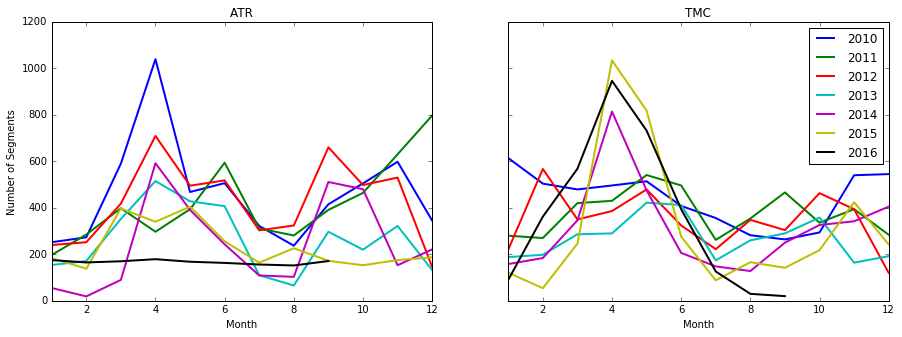

In [103]:
data1 = data[data['year']>2009]
data1 = data1[['year','month','count_type','dir_bin','centreline_id']].drop_duplicates()
data1['year'] = data1['year'].astype(int)
fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(15,5))
ax1.set_xlim(1,12)
ax2.set_xlim(1,12)
for (year,count_type),group in data1.groupby(['year','count_type']):
    g1 = group.groupby(['month'],as_index=False).size()
    if count_type == 1:
        ax1.plot(g1.index,g1.values,label=int(year),linewidth=2)
    else:
        ax2.plot(g1.index,g1.values,label=int(year),linewidth=2)
plt.legend()
plt.title('Number of Segments by Month')
ax1.set_title('ATR')
ax2.set_title('TMC')
ax1.set_xlabel('Month')
ax2.set_xlabel('Month')
ax1.set_ylabel('Number of Segments')
plt.show()

### 7. Number of Segments Counted by Road Type 
A summary of the road types (i.e. major arterial, minor arterial, collector, etc.) with available counts, by year.

In [7]:
# Time in scope
data1 = data[data['year']>2000]
data1 = pd.DataFrame(data1.groupby(['year','feature_code_desc']).centreline_id.nunique())
data1.reset_index(inplace=True)
# Set road types in scope
combine = list(data1['feature_code_desc'].unique())
combine.remove('Local')
combine.remove('Major Arterial')
combine.remove('Major Arterial Ramp')
combine.remove('Minor Arterial')
combine.remove('Collector')
combine.remove('Collector Ramp')
combine.remove('Expressway')
combine.remove('Expressway Ramp')
combine.remove('Laneway')

data1['year'] = data1['year'].astype(int)

# Construct Cross Tabulation
data1 = pd.crosstab(data1['year'],data1['feature_code_desc'],values=data1.centreline_id,aggfunc=np.sum,margins=True)
# Combine minor road Types
data1['Others'] = data1[combine].sum(axis=1)
data1.drop(combine, axis=1, inplace=True)
data1 = data1[list(data1.columns[0:-2]) + list(data1.columns[-1:]) + list(data1.columns[-2:-1])]
del data1.index.name
del data1.columns.name
data1 = data1.fillna(0)
data1[data1.columns] = data1[data1.columns].astype(int)

data1

,Collector,Collector Ramp,Expressway,Expressway Ramp,Laneway,Local,Major Arterial,Major Arterial Ramp,Minor Arterial,Others,All
2001,563,2,54,89,37,948,1493,9,564,26,3785
2002,591,0,43,59,29,943,1707,6,592,27,3997
2003,690,2,40,65,10,1061,1938,37,785,46,4674
2004,698,0,51,85,19,1000,1574,11,850,37,4325
2005,688,0,73,119,33,924,1557,11,846,39,4290
2006,715,0,60,76,33,1240,1661,18,609,37,4449
2007,966,5,57,99,17,902,1491,30,586,54,4207
2008,547,1,60,75,18,564,1410,12,620,43,3350
2009,787,2,76,67,20,731,1482,5,805,41,4016
2010,661,0,77,82,26,905,1624,16,760,56,4207


### 8. Daily Totals by Road Class
A summary of the distribution of daily volume totals separated by road types (i.e. major arterial, minor arterial, collector, etc.)

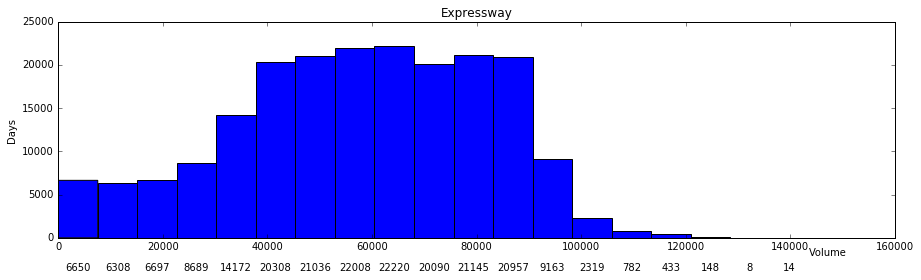

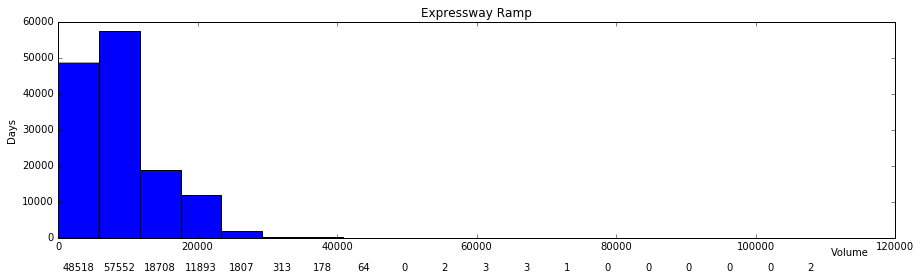

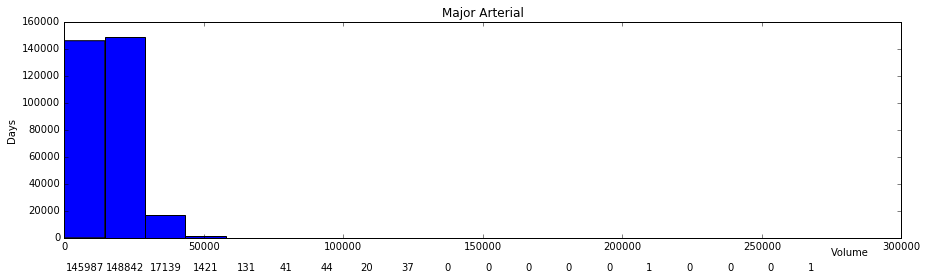

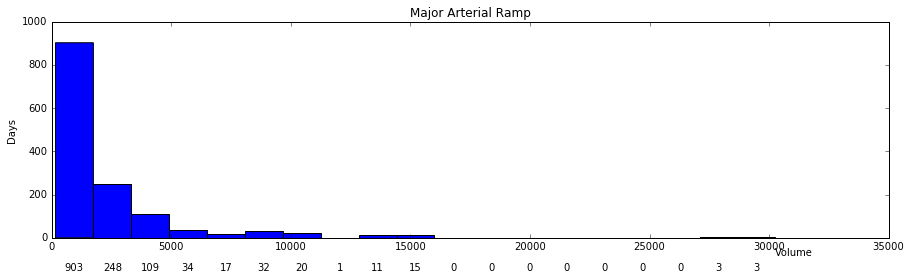

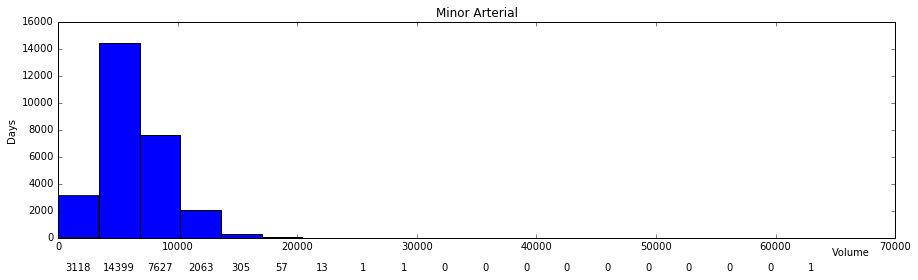

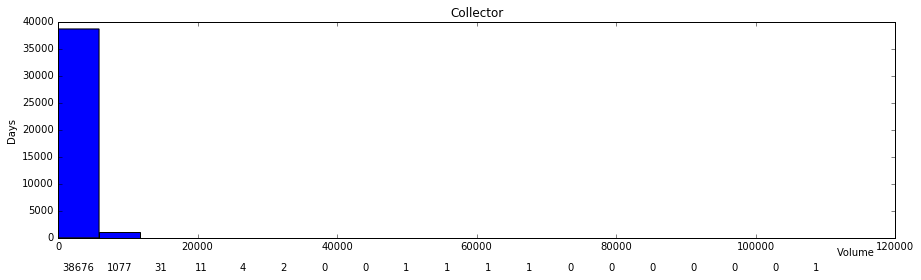

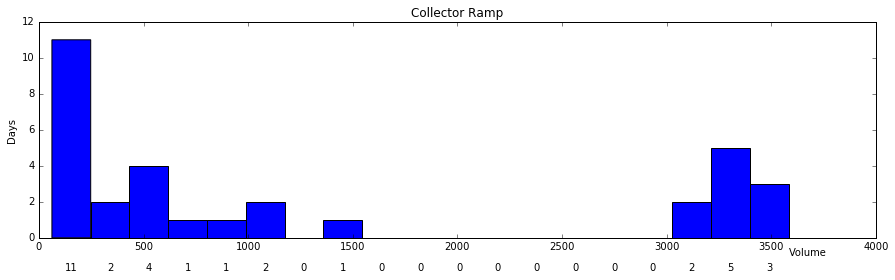

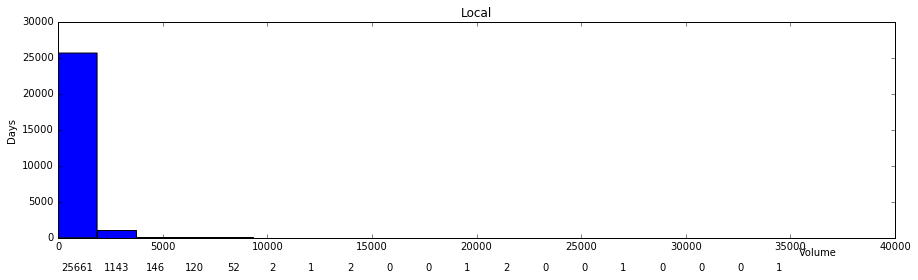

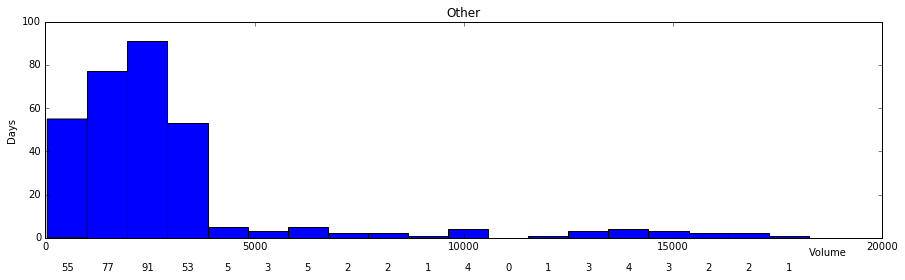

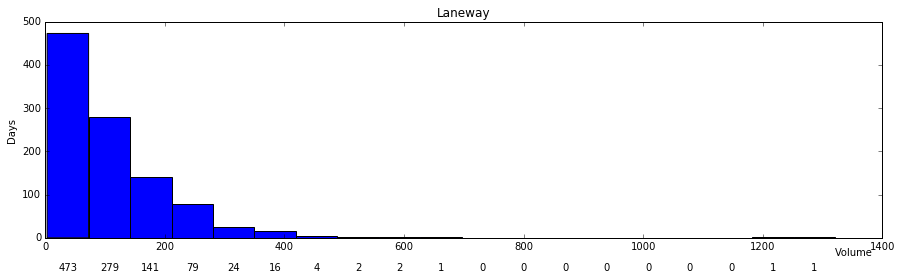

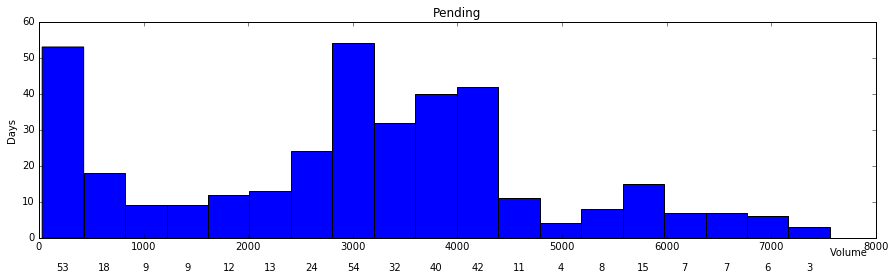

In [8]:
data_tvrc = pd.read_csv('ATR Daily Volume.csv')
for (fc,fc_desc),group in data_tvrc.groupby(['feature_code','feature_code_desc']):
    maxValue = max(group['sum'])//1000 *1000 
    fig, ax = plt.subplots(figsize = [15,4])
    n,bins,patches=plt.hist(group['sum'],bins=19,color='b')
    binsize = bins[2] - bins [1]
    for count,x in zip (n,bins[:-1]):
        ax.annotate(str(int(count)), xy=(x+binsize/2,0), xycoords=('data', 'axes fraction'),
            xytext=(0, -25), textcoords='offset points', va='top', ha='center')
    plt.subplots_adjust(bottom=0.15)
    plt.title(fc_desc)
    ax.annotate('Volume', xy=(max(group['sum']),0), xycoords=('data', 'axes fraction'), 
        xytext=(0, -10), textcoords='offset points', va='top', ha='left')
    ax.set_ylabel('Days')


In [104]:
db.close()